## Havvind - Integrated potential density anomaly at Sørvest-F and Nordvest-C

Potential density have been calculated for all daily reference and experiment files. Files are found in: `/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_mld`, with output variable named `pd`. This is the total potential density, not anomaly. It was calculated by interpolating potential temperature and salinity from s-levels to z-levels.

Potential density anomaly is already an output variable in the reference and experiment files, however they are on s-levels. As I want to integrated over depth and save some time, I will use the already interpolated potential density.

I think the integrated potential density anomaly is the same as the potential energy anomaly? In https://doi.org/10.1016/j.ocemod.2007.12.003 it is defined as 
$$\varphi = \frac{1}{H} \int_{-h}^{\eta}(\bar{\rho} - \rho) gz dz$$

"...where ρ is the vertical density profile over the water column of depth H, given by H = η + h, η the free surface, h the location of the bed, $\bar\rho$
 the depth averaged density, z the vertical co-ordinate and g the gravitational acceleration. For a given density profile, φ (J/m3) represents the amount of work required to bring about complete vertical mixing per unit of volume."

 From https://doi.org/10.3389/fmars.2025.1531684 we have the same definition, and they say "The potential energy anomaly (ϕ) and its derivative (ϕ_t) are used to evaluate the competition between mixing and stratification in the water column and the processes that cause it. ϕ explains the amount of mechanical energy (per m3) required to reach a specific density profile in the water column with a given density profile. "

 Okay my thoughts:

 My first immediate thought was to do $$\int_{-H}^{0} \rho' dz$$, but that doesn't really make much sense I think. Because what I think we want to know is if the turbines and changed wind stress alters mixing. If we look at the potential energy however, we get a feel for the mixing. Higher potential energy would be more mixed and vice versa. Meaning we would go with the equation found in the other papers above. Because if there is more or less mixing in the presence of wind farms, a change in potential energy of the column would be seen. 

The `pea` function from https://github.com/metno/FOCCUS/blob/main/coastal_system/model_diagnostics/WaterMassProperties.py uses a reference value of the density of 1027 kgm⁻3 instead of using the depth averaged density (as in textbooks). Also, they use a maximum depth to to integrate over. Should this maybe be the mixed layer depth fot hat location at that time? 


__https://link.springer.com/article/10.1007/s00382-019-04816-y__
* From the book above I find a different definition again, which also impacts how I calculated MLD earlier.
* Here they want to investigate the seasonal stratification or the 'difficulty in mixing' due to stability. Quantitatively represented by the potential energy anomaly.
* The definition used is: $\phi = \frac{1}{H}\int_{H}^{0} (\bar \rho - \rho)gz dz$ where $\bar\rho=\frac{1}{H}\int_{H}^{0}\rho dz$. Such that the integration for $\phi$ is over the deviation from vertically averaged potential density.
* Further they write: 'since the focus of this work is the layer of the ocean where the density shows seasonal variation, we set the lower limit in the PEA calculation (H) to the local annual maximum of the ML depth'.
* AKA I was right:)))) I should use the MLD as the integration boundary, but I dont have an annual maxima. I guess just max MLD of the gridpoint over the available times then?
* They also write how they define MLD, which differs from how I did it... MLD dfined as depth above threshold of surface + 0.125 kgm⁻3, where the surface is taken to be at 5 m depth.
* I calculated MLD with surface as literal surface, and threshold as 0.03 kgm⁻3.

BUT! Who do I listen to???? Kai, my boss and supervisor, or random books and articles online.:)

Starting with making a grid, opening turbine coordinates, extracting the files containing potential density, calculating the Rossby radius and making a study area of $50R_1$ x $50R_1$ around the wind farms (where the Rossby deformation radius is the area mean of June), and getting out the z-levels which the data was interpolated to.

In [14]:
%load_ext autoreload
%autoreload 2

from Rossby_deformation.get_turbine_coords import get_turbine_coords
from Rossby_deformation.funcs import *
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import cartopy.feature as cfeature

mplstyle.use(['ggplot', 'fast'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Making a grid
path = '/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-03/norkyst_avg_0001.nc'
fid = Dataset(path)
grid = SGrid(fid)
del fid

In [16]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')
nordvest_C = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Nordvest_C.txt')

In [17]:
# Square around wind park
min_lon_SV = np.min(sorvest_F.coordinates[:,0].values)
min_lat_SV = np.min(sorvest_F.coordinates[:,1].values)
max_lon_SV = np.max(sorvest_F.coordinates[:,0].values)
max_lat_SV = np.max(sorvest_F.coordinates[:,1].values)

area_lon_SV = [min_lon_SV, max_lon_SV]
area_lat_SV = [min_lat_SV, max_lat_SV]

In [18]:
# Square around wind park
min_lon_NV = np.min(nordvest_C.coordinates[:,0].values)
min_lat_NV = np.min(nordvest_C.coordinates[:,1].values)
max_lon_NV = np.max(nordvest_C.coordinates[:,0].values)
max_lat_NV = np.max(nordvest_C.coordinates[:,1].values)

area_lon_NV = [min_lon_NV, max_lon_NV]
area_lat_NV = [min_lat_NV, max_lat_NV]

In [19]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_bdr/REF')

# Only using June because we want the largest Rossby radius
months = {
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [20]:
# Internal Rossby radius of June - from area of wind parks
R1_june_SV = monthly_mean_area(files, grid, area_lon_SV, area_lat_SV)
R1_june_SV = R1_june_SV.gamma_r

# Internal Rossby radius of June - from area of wind parks
R1_june_NV = monthly_mean_area(files, grid, area_lon_NV, area_lat_NV)
R1_june_NV = R1_june_NV.gamma_r

In [21]:
zlevs = np.arange(0,51,1)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(52,102,2), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(105,305,5), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(520,1020,20), axis =0)
zlevs = np.insert(zlevs,len(zlevs),values=np.arange(1050,3050,50), axis =0)

zlevs = zlevs[np.where(zlevs<=np.max(grid.h))]
zlevs = np.array(zlevs)*-1.

In [23]:
# Extracting filepaths to MLD for the reference runs

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_mld/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files_ref=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_mld.nc'
        files_ref.append(filefolder[0]+file_path)

In [24]:
# Extracting filepaths to MLD for the experiments

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_mld/EXP')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files_exp=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/EXP_{month}_norkyst_avg_{day_str}_mld.nc'
        files_exp.append(filefolder[0]+file_path)

In [119]:
ds_ref = xr.open_dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-03/norkyst_avg_0001.nc')
zeta = ds_ref.zeta
del ds_ref

In [135]:
ds_ref = xr.open_dataset('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_mld/REF/REF_03_norkyst_avg_0001_mld.nc')
#ds_ref = ds_ref.expand_dims(dim={'depth': zlevs})
pd = ds_ref.pd 

In [137]:
ds_ref.mld

<xarray.DataArray 'mld' (ocean_time: 1, eta_rho: 1148, xi_rho: 2747)>
[3153556 values with dtype=float64]
Coordinates:
  * ocean_time  (ocean_time) float64 1.646e+09
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  Mixed layer depth
    units:      meter

In [123]:
depth = grid.h
mask = grid.mask_rho
z_r = grid.z_r
g = 9.81
rhoref = 1027


In [132]:
test_pea = xr.open_dataset('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_pea/tests/REF_02_norkyst_avg_0001_pea.nc')

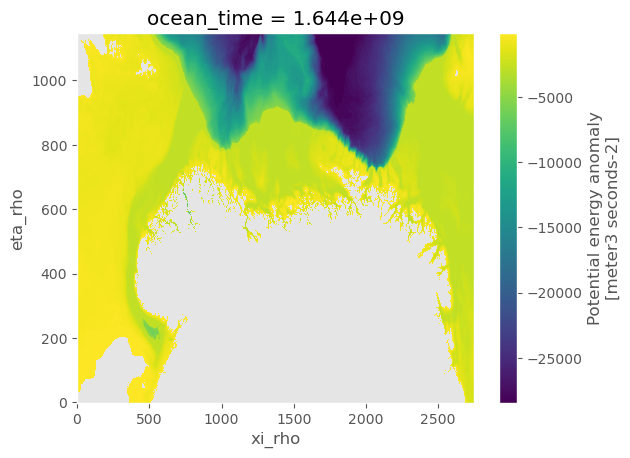

In [134]:
test_pea.pea[0, :, :].plot()

In [147]:
test = xr.open_dataset('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_pea/tests/REF_02_norkyst_avg_0001_pea_test_divide_depth_use_mld.nc')

The below is from using the reference value of Kai, dividing with rhoref as kai, but also dividing by depth. Some sign error tho.

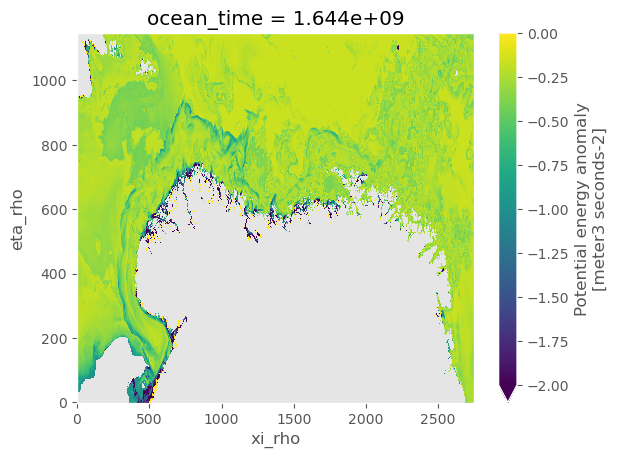

In [150]:
test.pea[0, :, :].plot(vmin=-2, vmax=0)

The below is not dividing by rhoref...

In [151]:
test = xr.open_dataset('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_pea/tests/REF_02_norkyst_avg_0001_pea_option2.nc')

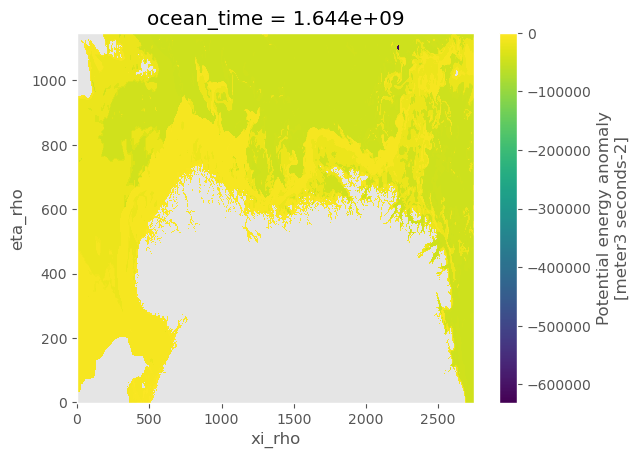

In [ ]:
test.pea[0, :, :].plot(vmin=-1000, vmax=0)

In [ ]:
test = xr.open_dataset('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_pea/tests/REF_02_norkyst_avg_0001_pea_try.nc')

In [ ]:
test.pea[0, :, :].plot(vmin=-1000, vmax=0)

# Options

From what I have read the options for potential energy anomaly are:

### 1) Kai's approach

$$\varphi = \int_{max depth}^{\eta} -g (\rho _{ref} - \rho) \frac{z}{\rho _{ref}} dz$$

$$[m^3 s^-2] $$

Where the max depth is believed to be some version of the mixed layer depth and the reference density value: "The reference density should be such that there is some reference waters in the area of interest. Keep in mind that maps based on the output from this function might appear strange if the chosen maximum depth is larger than the minimum depth of the model, hence it is best to mask the map where the local depth is smaller than the maximum depth." In Kai's script set to be 1027 kgm⁻3. 

### 2) https://doi.org/10.1007/s00382-019-04816-y

$$\varphi = \frac{1}{H}\int_{MLD}^{0} (\bar\rho - \rho) gz dz$$

$$[J m^-3] $$

where $\bar \rho$ is the vertical mean potential density.

### 3) https://doi.org/10.1016/j.ocemod.2007.12.003 

$$\varphi = \frac{1}{H} \int_{-h}^{\eta}(\bar{\rho} - \rho) gz dz$$

$$[J m^-3] $$

where $\bar \rho$ is the vertical mean potential density, and $H$ the water depth.


### Thoughts
We want to see if wind turbines yield more or less mixing of the upper layer. More mixing results in a higher potential energy anomaly because denser waters would be found higher in the water column. Option 2 and 3 have units energy per volume, i.e. how much potential energy in this column of water. But what do you compare it to? A set reference or the mean of the column? What does it mean if you compare the density of the column with the mean vs a reference value?

If you use the columns mean, you can only compare it to itself (??), whereas using a set reference value you can compare columns all over??? Idk man. Kai's method normalizes the anomaly, whereas the other ones dont. They divide by depth, so shallower waters more potential energy??

It should be noted, that both the articles above are looking into more of a global scale... maybe that matters too. 

